In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy.interpolate import splprep, splev
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from skimage import filters, measure, morphology
from scipy.ndimage import gaussian_filter
import os

# Define two simple shapes: circle and square
def create_circle(center=(100, 100), radius=40, size=(200, 200)):
    y, x = np.ogrid[:size[0], :size[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    return mask.astype(np.uint8)

def create_square(top_left=(60, 60), length=80, size=(200, 200)):
    mask = np.zeros(size, dtype=np.uint8)
    mask[top_left[1]:top_left[1]+length, top_left[0]:top_left[0]+length] = 1
    return mask

def create_diamond(center=(100, 100), size=80, img_size=(200, 200)):
    y, x = np.ogrid[:img_size[0], :img_size[1]]
    mask = np.abs(x - center[0]) + np.abs(y - center[1]) <= size // 2
    return mask.astype(np.uint8)

# Extract contour
def extract_contour(binary_mask):
    contours = measure.find_contours(binary_mask, 0.5)
    largest = max(contours, key=len)
    return largest[:, 1], largest[:, 0]

# Resample to fixed number of points
def resample_contour(x, y, num_points=256):
    tck, u = splprep([x, y], s=0, per=True)
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    return np.array(x_new), np.array(y_new)

# Fourier Descriptor functions
def compute_fd(x, y):
    z = x + 1j * y
    Z = np.fft.fft(z)
    return Z

def normalize_fd(Z):
    Z[0] = 0
    Z /= np.abs(Z[1])
    return Z

def interpolate_fd_sequence(fd_seq, t_vals, target_t):
    fd_array = np.array(fd_seq)
    interpolated = []
    for k in range(fd_array.shape[1]):
        real_interp = np.interp(target_t, t_vals, fd_array[:, k].real)
        imag_interp = np.interp(target_t, t_vals, fd_array[:, k].imag)
        interpolated.append(real_interp + 1j * imag_interp)
    return np.array(interpolated)

def reconstruct_shape(Z):
    z = np.fft.ifft(Z)
    return z.real, z.imag

def morph_fourier(fd_large, fd_small, g):
    """
    Morph two shapes in Fourier descriptor space.
    fd_large, fd_small: complex Fourier descriptors (same length)
    g: interpolation parameter between 0 and 1
    """
    fd_morphed = (1 - g) * fd_large + g * fd_small
    return fd_morphed

def reconstruct_contour(fd):
    """
    Reconstruct contour from Fourier descriptors.
    """
    z_reconstructed = np.fft.ifft(fd)
    return z_reconstructed.real, z_reconstructed.imag

# Create masks
circle_mask = create_circle()
square_mask = create_square()

# Extract, resample, and compute FDs
x1, y1 = extract_contour(circle_mask)
x1, y1 = resample_contour(x1, y1)
Z1 = normalize_fd(compute_fd(x1, y1))

x2, y2 = extract_contour(square_mask)
x2, y2 = resample_contour(x2, y2)
Z2 = normalize_fd(compute_fd(x2, y2))



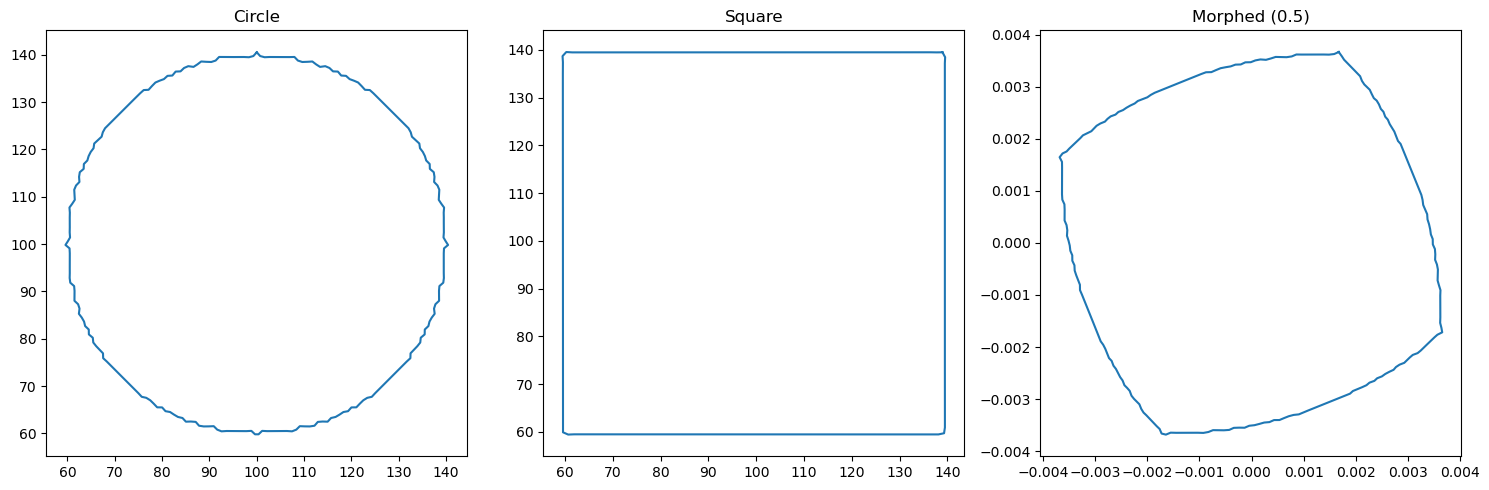

In [5]:
# Morph at mid-point
Z_morphed = interpolate_fd_sequence([Z1, Z2], [0, 1], 0.5)
x_morph, y_morph = reconstruct_shape(Z_morphed)

# # paper
# g = 0.5  # halfway morph
# # Morph the Fourier descriptors
# fd_morphed = morph_fourier(Z1, Z2, g)
# # Reconstruct the morphed contour
# x_morph, y_morph = reconstruct_contour(fd_morphed)


# Plot original and morphed shapes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(x1, y1)
axs[0].set_title("Circle")
axs[0].axis("equal")

axs[1].plot(x2, y2)
axs[1].set_title("Square")
axs[1].axis("equal")

axs[2].plot(x_morph, y_morph)
axs[2].set_title("Morphed (0.5)")
axs[2].axis("equal")

plt.tight_layout()
plt.show()


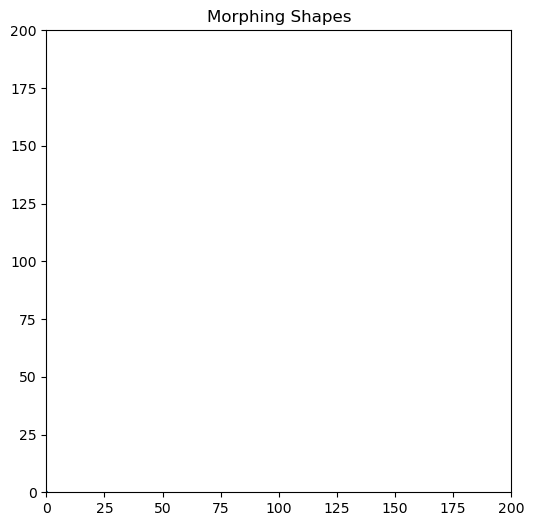

In [10]:
import matplotlib.animation as animation
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter 

# Generate interpolated shapes
n_frames = 30
times = np.linspace(0, 1, n_frames)
shapes = [reconstruct_shape(interpolate_fd_sequence([Z1, Z2], [0, 1], t)) for t in times]

# Create animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_title("Morphing Shapes")
line, = ax.plot([], [], lw=2)
def init():
    line.set_data([], [])
    return line,
def update(frame):
    x, y = shapes[frame]
    line.set_data(x, y)
    return line,
ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True)
ani.save("morphing_shapes.gif", writer=PillowWriter(fps=10))
plt.show()

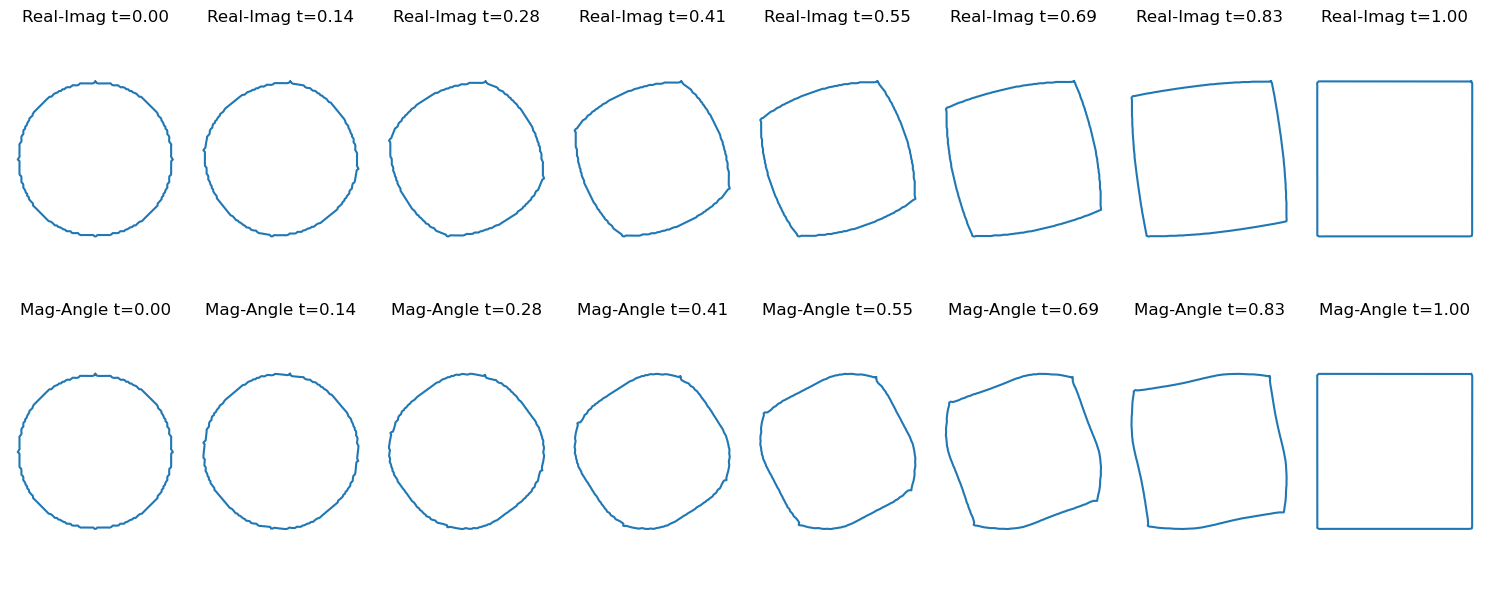

In [3]:
# Interpolation in magnitude-phase space
def interpolate_fd_magnitude_angle(fd_seq, t_vals, target_t):
    fd_array = np.array(fd_seq)  # shape: (T, N)
    interpolated = []

    for k in range(fd_array.shape[1]):
        mag = np.abs(fd_array[:, k])
        angle = np.angle(fd_array[:, k])

        # Handle angle wrapping
        def interp_angle(theta1, theta2, t):
            diff = ((theta2 - theta1 + np.pi) % (2 * np.pi)) - np.pi
            return theta1 + t * diff

        mag_interp = np.interp(target_t, t_vals, mag)
        angle_interp = interp_angle(angle[0], angle[1], (target_t - t_vals[0]) / (t_vals[1] - t_vals[0]))

        interpolated.append(mag_interp * np.exp(1j * angle_interp))

    return np.array(interpolated)

# Create both real-imag and magnitude-angle interpolations
shapes_real_imag = [reconstruct_shape(interpolate_fd_sequence([Z1, Z2], [0, 1], t)) for t in times]
shapes_mag_angle = [reconstruct_shape(interpolate_fd_magnitude_angle([Z1, Z2], [0, 1], t)) for t in times]

# Plot side-by-side comparison for selected frames
fig, axs = plt.subplots(2, 8, figsize=(15, 6))
selected = np.linspace(0, n_frames - 1, 8, dtype=int)

for i, idx in enumerate(selected):
    x1, y1 = shapes_real_imag[idx]
    x2, y2 = shapes_mag_angle[idx]
    
    axs[0, i].plot(x1 - np.mean(x1), y1 - np.mean(y1))
    axs[0, i].set_title(f"Real-Imag t={times[idx]:.2f}")
    axs[0, i].axis('equal')
    axs[0, i].axis('off')
    
    axs[1, i].plot(x2 - np.mean(x2), y2 - np.mean(y2))
    axs[1, i].set_title(f"Mag-Angle t={times[idx]:.2f}")
    axs[1, i].axis('equal')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def process_image_get_largest_contour(img, rgb):
    
    # Mask by RGB values
    r = rgb[:, :, 0]
    g = rgb[:, :, 1]
    b = rgb[:, :, 2]

    rgb_sum = r + g + b + 1e-6  # prevent divide-by-zero
    r_norm = r / rgb_sum
    g_norm = g / rgb_sum
    b_norm = b / rgb_sum
    mask = ( 
        (b_norm > 0.331) &          
        (g_norm > 0.331) &       
        (r_norm > 0.331)  
    )

    # Morph cleanup
    clean_mask = morphology.opening(mask, morphology.disk(2))  # remove small bright spots
    clean_mask = morphology.closing(mask, morphology.disk(3)) # fill small gaps
    clean_mask = morphology.remove_small_objects(clean_mask, min_size=1000)
    clean_mask = morphology.remove_small_holes(clean_mask, area_threshold=1000)
    
    # Find contours, get biggest
    contours = measure.find_contours(clean_mask, level=0.5)
    return max(contours, key=lambda c: len(c))
    
img_folder = 'QC/'
# loop thru all images in the folder
images = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith('.png')]
# sort by name
images.sort()
# print size of image 1
img = Image.open(images[9])
print(f"Image size: {img.size}")
print(len(images))

ice_contours = []
for i, img in enumerate(images):
    img = Image.open(img).convert('RGB')
    # # crop to 900x900
    # img = img.crop((0, 0, 900, 900))
    rgb = np.array(img).astype(np.float32)/255
    largest_contour = process_image_get_largest_contour(img, rgb)
    ice_contours.append((largest_contour[:, 1], largest_contour[:, 0])) # x=col, y=row


from shapely.geometry import LineString
import numpy as np

def resample_contour(x, y, N=500):
    """
    Resample the contour to N evenly spaced points
    """
    # Close the loop
    if x[0] != x[-1] or y[0] != y[-1]:
        x = np.append(x, x[0])
        y = np.append(y, y[0])

    line = LineString(zip(x, y))
    length = line.length
    # evenly spaced distances along the line
    distances = np.linspace(0, length, N)
    sampled_points = [line.interpolate(distance) for distance in distances]

    # Extract new x and y
    x_resampled = np.array([point.x for point in sampled_points])
    y_resampled = np.array([point.y for point in sampled_points])

    return x_resampled, y_resampled


Image size: (996, 1204)
37


In [14]:
print(len(ice_contours))

6


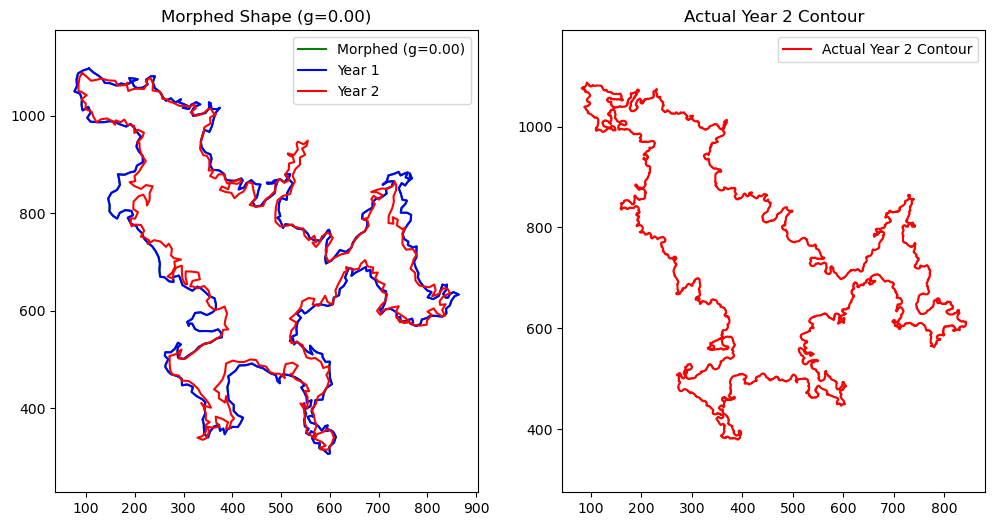

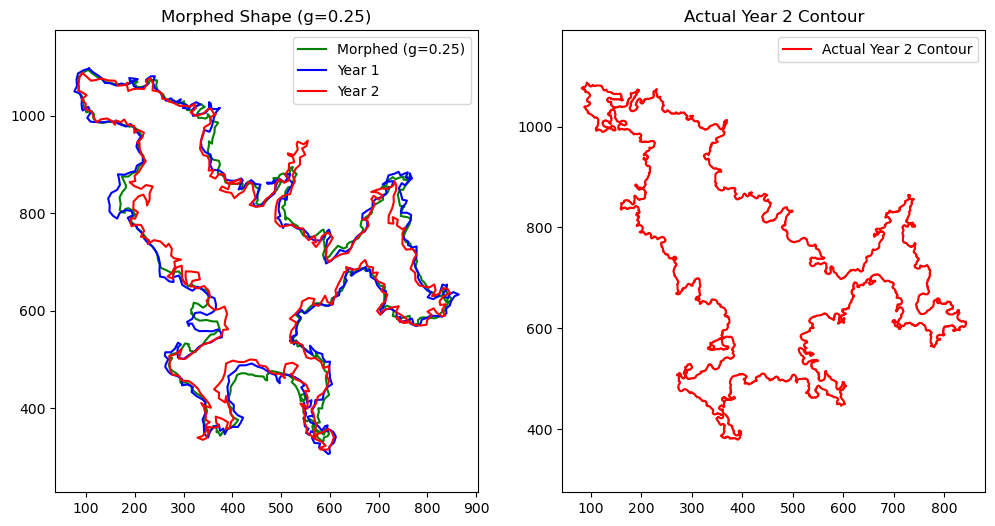

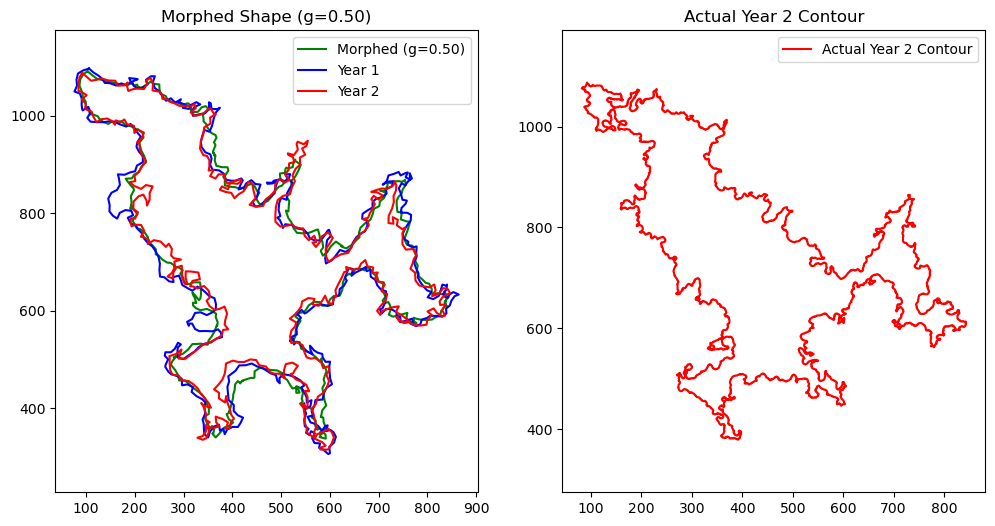

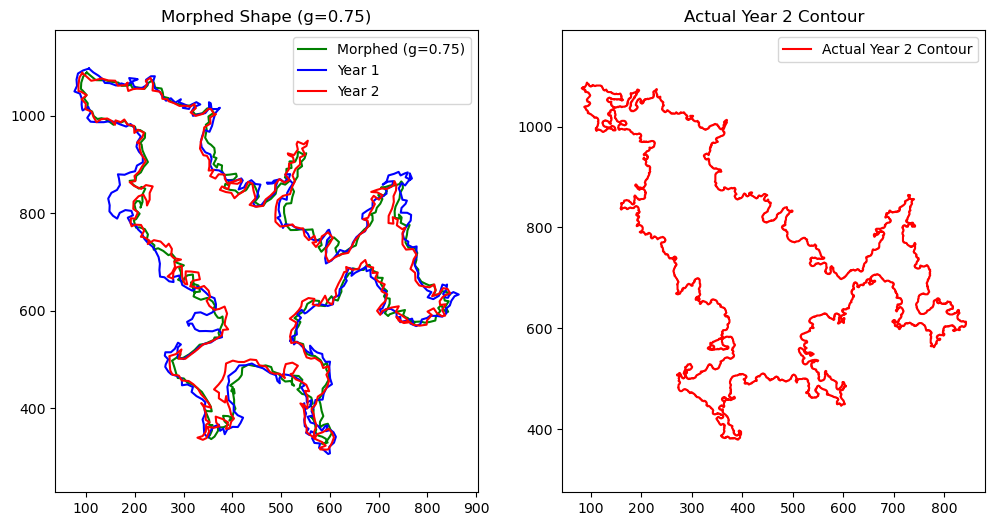

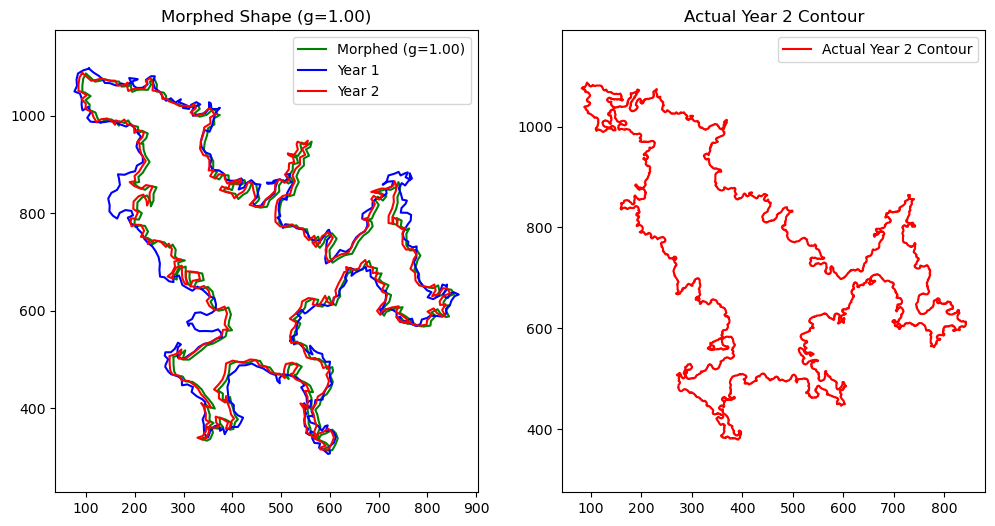

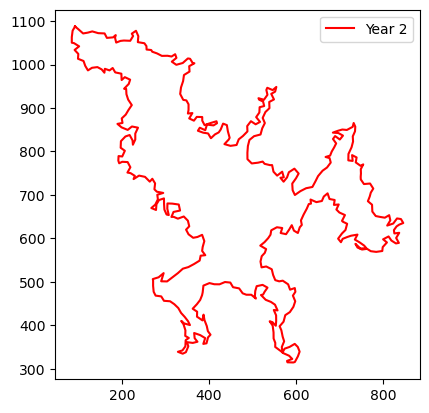

In [30]:
# Get the contours of two years
(x1, y1) = ice_contours[0]  
(x2, y2) = ice_contours[5] 

N = 500
x1_res, y1_res = resample_contour(x1, y1, N=N)
x2_res, y2_res = resample_contour(x2, y2, N=N)

z1 = (x1_res - np.mean(x1_res)) + 1j * (y1_res - np.mean(y1_res)) # center
z2 = (x2_res - np.mean(x2_res)) + 1j * (y2_res - np.mean(y2_res))

fd1 = np.fft.fft(z1)
fd2 = np.fft.fft(z2)

def morph_fourier(fd_large, fd_small, g):
    return (1 - g) * fd_large + g * fd_small

years = 5
x_orig, y_orig = x1_res, y1_res  # For overlaying
for g in np.linspace(0, 1, years):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fd_morphed = morph_fourier(fd1, fd2, g)
    x_morph, y_morph = reconstruct_contour(fd_morphed)
    # Align morphed shape to Year 1 centroid
    x_morph = x_morph - np.mean(x_morph) + np.mean(x1_res)
    y_morph = y_morph - np.mean(y_morph) + np.mean(y1_res)
    # Plot morphed
    axes[0].plot(x_morph, y_morph, 'g-', label=f'Morphed (g={g:.2f})')
    axes[0].plot(x1_res, y1_res, 'b-', label='Year 1')
    axes[0].plot(x2_res, y2_res, 'r-', label='Year 2')
    axes[0].set_title(f'Morphed Shape (g={g:.2f})')
    axes[0].axis('equal')
    axes[0].legend()
    #! actual contour for the year on the right
    axes[1].plot(ice_contours[4][0], ice_contours[4][1], 'r-', label='Actual Year 2 Contour')
    axes[1].set_title('Actual Year 2 Contour')
    axes[1].axis('equal')
    axes[1].legend()
    plt.show()
plt.plot(x2_res, y2_res, 'r-', label='Year 2')
plt.gca().set_aspect('equal')
plt.legend()
plt.show()


In [35]:
def create_square_contour(top_left=(60, 60), length=80, N=256):
    """
    Create a square contour with N resampled boundary points.
    """
    x0, y0 = top_left
    corners = [
        (x0, y0),
        (x0 + length, y0),
        (x0 + length, y0 + length),
        (x0, y0 + length),
        (x0, y0)  # close the loop
    ]
    # Extract corners
    x_corners, y_corners = zip(*corners)

    from shapely.geometry import LineString
    square_line = LineString(list(zip(x_corners, y_corners)))

    # Evenly spaced points along the boundary
    distances = np.linspace(0, square_line.length, N)
    sampled_points = [square_line.interpolate(d) for d in distances]

    x_resampled = np.array([pt.x for pt in sampled_points])
    y_resampled = np.array([pt.y for pt in sampled_points])

    return x_resampled, y_resampled


In [ ]:
def create_square(N=256):
    return create_square_contour(N=N)

def create_circle(N=256, center=(100, 100), radius=50):
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return x, y

def create_triangle(N=256):
    corners = [(50, 150), (150, 150), (100, 50)]
    from shapely.geometry import LineString
    line = LineString(corners + [corners[0]])
    distances = np.linspace(0, line.length, N)
    points = [line.interpolate(d) for d in distances]
    x = np.array([p.x for p in points])
    y = np.array([p.y for p in points])
    return x, y



In [43]:
def normalize_fd(Z):
    Z[0] = 0
    Z /= np.abs(Z[1])
    return Z
  
def compute_fd(x, y, normalize=True):
    z = x + 1j * y
    Z = np.fft.fft(z)
    return normalize_fd(Z) if normalize else Z
  
def low_pass(Z, num_points=256):
    Z_ = np.zeros_like(Z, dtype=complex)
    Z_[0] = Z[0]
    Z_[1:num_points//2] = Z[1:num_points//2]
    Z_[-num_points//2+1:] = Z[-num_points//2+1:]
    return Z_
  
def reconstruct_shape(Z):
    z = np.fft.ifft(Z)
    return z.real, z.imag

In [ ]:
# slc_contour = np.load('/Users/emilyguan/Downloads/MIA/fourier-morph/SLC/SLC_mask_2015.npy')
slc_contour = np.load('/Users/emilyguan/Downloads/MIA/fourier-morph/SLC/SLC_mask_2015.npy')
x1, y1 = extract_contour(slc_contour)
P1 = compute_fd(x1, y1, normalize=True)
num_params = 256
# slc_contour = low_pass(P1, num_params)

x_glacier, y_glacier = resample_contour(x1, y1, N=256)


In [ ]:
def to_complex(x, y):
    return (x - np.mean(x)) + 1j * (y - np.mean(y))

def get_fd(z):
    return np.fft.fft(z)

def reconstruct_fd(fd, n):
    # Zero out high frequencies
    fd_truncated = np.zeros_like(fd)
    fd_truncated[:n] = fd[:n]
    if n > 1:
        fd_truncated[-n+1:] = fd[-n+1:]
    z_reconstructed = np.fft.ifft(fd_truncated)
    return z_reconstructed.real, z_reconstructed.imag


In [109]:
N = 256
x_square, y_square = create_square(N)
x_circle, y_circle = create_circle(N)
x_triangle, y_triangle = create_triangle(N)

z_square = to_complex(x_square, y_square)
z_circle = to_complex(x_circle, y_circle)
z_triangle = to_complex(x_triangle, y_triangle)
z_glacier = to_complex(x_glacier, y_glacier)

fd_square = get_fd(z_square)
fd_circle = get_fd(z_circle)
fd_triangle = get_fd(z_triangle)
fd_glacier = get_fd(z_glacier)

import matplotlib.pyplot as plt

shapes = [
    ("Square", fd_square),
    # ("Circle", fd_circle),
    ("Triangle", fd_triangle),
    ("Glacier", fd_glacier)
]

n_values = [1, 2, 5, 10, 14, 128] # is actually half the real n, fourier uses double this


/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersect

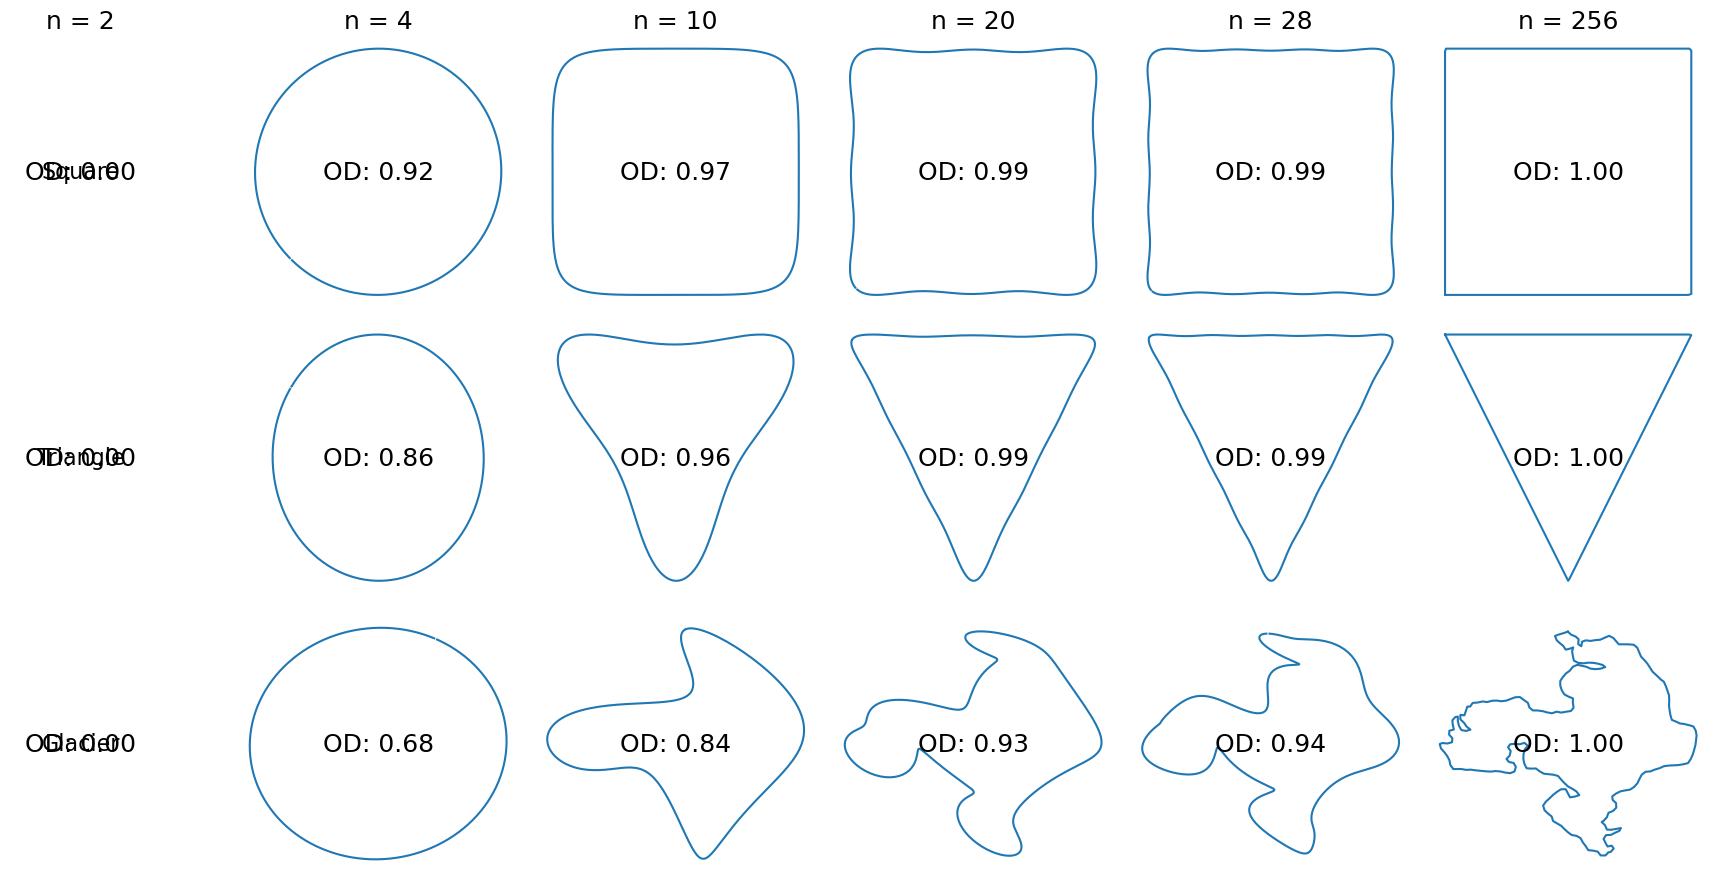

In [115]:
from shapely.geometry import Polygon

def compute_od(x_orig, y_orig, x_rec, y_rec):
    """
    Compute the Overlap Degree (OD) between original and reconstructed shapes.
    """
    if (x_orig[0] != x_orig[-1]) or (y_orig[0] != y_orig[-1]):
        x_orig = np.append(x_orig, x_orig[0])
        y_orig = np.append(y_orig, y_orig[0])
    if (x_rec[0] != x_rec[-1]) or (y_rec[0] != y_rec[-1]):
        x_rec = np.append(x_rec, x_rec[0])
        y_rec = np.append(y_rec, y_rec[0])
    poly_orig = Polygon(np.column_stack((x_orig, y_orig)))
    poly_rec = Polygon(np.column_stack((x_rec, y_rec)))

    if not poly_orig.is_valid or not poly_rec.is_valid:
        return 0  # If either polygon is invalid (e.g., self-intersecting), return OD=0

    intersection_area = poly_orig.intersection(poly_rec).area
    od = intersection_area / poly_orig.area

    return od

od_results = {}

fig, axs = plt.subplots(len(shapes), len(n_values), figsize=(3*len(n_values), 3*len(shapes)))

for i, (label, fd) in enumerate(shapes):
    od_results[label] = []
    # Original contour for this shape
    if label == "Square":
        x_orig, y_orig = x_square, y_square
    elif label == "Circle":
        x_orig, y_orig = x_circle, y_circle
    elif label == "Triangle":
        x_orig, y_orig = x_triangle, y_triangle
    elif label == "Glacier":
        x_orig, y_orig = x_glacier, y_glacier

    for j, n in enumerate(n_values):
        x_rec, y_rec = reconstruct_fd(fd, n)
        axs[i, j].plot(x_rec, y_rec)
        axs[i, j].set_aspect('equal')
        axs[i, j].axis('off')

        x_rec = x_rec - np.mean(x_rec) + np.mean(x_orig)
        y_rec = y_rec - np.mean(y_rec) + np.mean(y_orig)
        od = compute_od(x_orig, y_orig, x_rec, y_rec)
        od_results[label].append(od)

        # Plot OD value in the center
        axs[i, j].text(0.5, 0.5, f'OD: {od:.2f}', fontsize=18,
                           transform=axs[i, j].transAxes,
                           verticalalignment='center',
                           horizontalalignment='center')

        if i == 0:
            axs[i, j].set_title(f'n = {int(n*2)}', fontsize=18)
        if j == 0:
            axs[i, j].text(0.5, 0.5, label, fontsize=16,
                           transform=axs[i, j].transAxes,
                           verticalalignment='center',
                           horizontalalignment='center')

plt.tight_layout()
plt.show()


In [102]:
print("Overlap Degree (OD) Results:")
for shape, od_values in od_results.items():
    print(f"{shape}: {od_values}")

Overlap Degree (OD) Results:
Square: [0, 0.9218252425396494, 0.9743575938330891, 0.9906543348939848, 0.9995072018448149, 1.0000000000000009]
Triangle: [0, 0.859012777665003, 0.961251956622664, 0.992453893757571, 0.9996435434630988, 0.9999824316839782]
Glacier: [0, 0.6794151937851621, 0.8424131251842526, 0.9271590084420251, 0.9894727614375163, 0.9996786189232327]
